# Getting Started

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

# get to the parent dir of mai_dul repo
import os
os.chdir('../../')
os.getcwd()

'/Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24'

In [2]:
# install latest version deepul package
!pip install -e .

Obtaining file:///Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
  DEPRECATION: Legacy editable install of deepul==0.1.0 from file:///Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24 (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for deepul


In [3]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

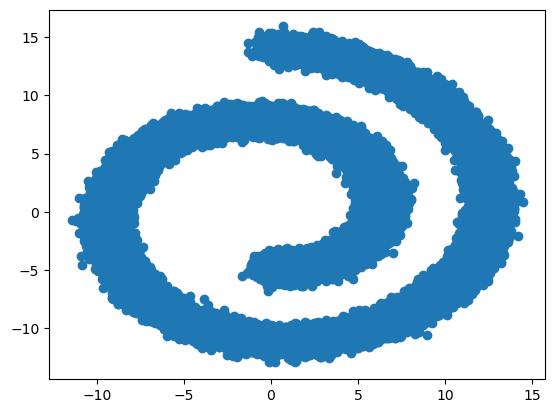

In [4]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

In [6]:
class DiffusionMLP(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x, t):
        # Concatenate input x with time t
        x_t = torch.cat([x, t.unsqueeze(-1)], dim=-1)
        return self.network(x_t)

In [7]:
def get_scheduler(optimizer, warmup_steps=100, max_steps=None):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, max_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [8]:
def get_noise_schedule(t):
    """Compute alpha_t and sigma_t using cosine schedule"""
    alpha_t = torch.cos(math.pi * t / 2)
    sigma_t = torch.sin(math.pi * t / 2)
    return alpha_t, sigma_t

In [9]:
def ddpm_update(x, eps_hat, t, t_prev):
    """Perform single DDPM update step"""
    alpha_t, sigma_t = get_noise_schedule(t)
    alpha_prev, sigma_prev = get_noise_schedule(t_prev)
    
    # Compute eta_t according to DDPM formula
    eta_t = (sigma_prev / sigma_t) * torch.sqrt(1 - (alpha_t**2 / alpha_prev**2))
    
    # Compute predicted x0
    x0_pred = (x - sigma_t * eps_hat) / alpha_t
    
    # Compute variance term (clip to avoid numerical issues)
    var_term = torch.clamp(sigma_prev**2 - eta_t**2, min=0)
    
    # Sample noise
    epsilon = torch.randn_like(x)
    
    # Compute next x
    x_prev = alpha_prev * x0_pred + torch.sqrt(var_term) * eps_hat + eta_t * epsilon
    
    return x_prev

In [10]:
def sample_diffusion(model, num_samples, num_steps, device):
    """Sample from the diffusion model using DDPM"""
    model.eval()
    
    # Initialize from normal distribution
    x = torch.randn(num_samples, 2).to(device)
    
    # Create timesteps
    ts = torch.linspace(1 - 1e-4, 1e-4, num_steps + 1).to(device)
    
    with torch.no_grad():
        for i in range(num_steps):
            t = ts[i]
            t_prev = ts[i + 1]
            
            # Get noise prediction
            eps_hat = model(x, t.expand(num_samples))
            
            # Update x
            x = ddpm_update(x, eps_hat, t, t_prev)
    
    return x.cpu().numpy()

In [11]:
def train_epoch(model, train_loader, optimizer, scheduler, device):
    """
    Train the model for one epoch.
    """
    model.train()
    train_losses = []
    
    pbar = tqdm(train_loader, unit='batch')
    
    for batch_id, batch in enumerate(pbar):
        x = batch[0].to(device)
        
        # Sample t and noise
        t = torch.rand(x.size(0)).to(device)
        epsilon = torch.randn_like(x)
        
        # Forward process
        alpha_t, sigma_t = get_noise_schedule(t)
        alpha_t = alpha_t.view(-1, 1)
        sigma_t = sigma_t.view(-1, 1)
        x_t = alpha_t * x + sigma_t * epsilon
        
        # Predict noise
        epsilon_pred = model(x_t, t)
        
        # Compute loss
        loss = torch.mean((epsilon - epsilon_pred) ** 2)
        
        # Optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_losses.append(loss.item())
        
        pbar.set_description(desc=f"Batch loss={loss:.4f}")
        # break
    
    return train_losses


In [12]:
def evaluate_loss(model, loader, device):
    """
    Evaluate model loss on given data loader.
    """
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in loader:
            x = batch[0].to(device)
            
            # Sample t and noise
            t = torch.rand(x.size(0)).to(device)
            epsilon = torch.randn_like(x)
            
            # Forward process
            alpha_t, sigma_t = get_noise_schedule(t)
            alpha_t = alpha_t.view(-1, 1)
            sigma_t = sigma_t.view(-1, 1)
            x_t = alpha_t * x + sigma_t * epsilon
            
            # Predict noise
            epsilon_pred = model(x_t, t)
            
            # Compute loss
            loss = torch.mean((epsilon - epsilon_pred) ** 2)
            total_loss += loss.item()
            # break
    
    return total_loss / len(loader)

In [13]:
def generate_samples(model, train_mean, train_std, num_samples=2000, device='cuda'):
    """
    Generate samples from the trained model with different numbers of steps.
    """
    step_range = np.power(2, np.linspace(0, 9, 9)).astype(int)
    all_samples = []
    
    for num_steps in step_range:
        samples = sample_diffusion(model, num_samples, num_steps, device)
        # Denormalize samples
        samples = samples * train_std + train_mean
        all_samples.append(samples)
    
    return np.stack(all_samples)

In [14]:
def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """

    torch.manual_seed(1)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() 
                         else "mps" if torch.backends.mps.is_available() 
                         else "cpu")
    print(f"Using device: {device}")
    
    # DataLoader settings based on device
    kwargs = {'num_workers': 8, 'pin_memory': True} if torch.cuda.is_available() else \
            {'num_workers': 8} if torch.backends.mps.is_available() else \
            {}

    # Hyperparameters
    hidden_dim = 64
    num_epochs = 100
    batch_size = 1024
    learning_rate = 1e-3

    # Normalize data
    train_mean = train_data.mean(axis=0)
    train_std = train_data.std(axis=0)
    train_normalized = (train_data - train_mean) / train_std
    test_normalized = (test_data - train_mean) / train_std

    # Convert to PyTorch tensors
    train_tensor = torch.FloatTensor(train_normalized)
    test_tensor = torch.FloatTensor(test_normalized)

    # Create data loaders
    train_dataset = TensorDataset(train_tensor)
    test_dataset = TensorDataset(test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, **kwargs)

    # Initialize model and optimizer
    model = DiffusionMLP(hidden_dim=hidden_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Setup scheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = get_scheduler(optimizer, warmup_steps=100, max_steps=total_steps)

    # Training
    train_losses = []
    test_losses = [evaluate_loss(model, test_loader, device)]
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Train one epoch
        epoch_losses = train_epoch(model, train_loader, optimizer, scheduler, device)
        train_losses.extend(epoch_losses)
        
        # Evaluate test loss
        test_loss = evaluate_loss(model, test_loader, device)
        test_losses.append(test_loss)

        # break
    
    # Generate samples
    samples = generate_samples(model, train_mean, train_std, num_samples=2000, device=device)

    # train_losses = []
    # test_losses = []
    # samples = []

    return np.array(train_losses), np.array(test_losses), samples

Using device: mps
Epoch 1/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 2/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 3/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 4/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 5/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 6/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 7/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 8/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 9/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 10/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 11/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 12/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 13/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 14/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 15/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 16/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 17/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 18/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 19/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 20/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 21/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 22/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 23/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 24/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 25/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 26/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 27/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 28/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 29/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 30/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 31/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 32/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 33/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 34/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 35/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 36/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 37/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 38/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 39/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 40/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 41/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 42/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 43/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 44/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 45/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 46/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 47/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 48/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 49/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 50/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 51/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 52/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 53/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 54/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 55/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 56/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 57/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 58/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 59/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 60/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 61/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 62/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 63/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 64/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 65/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 66/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 67/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 68/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 69/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 70/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 71/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 72/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 73/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 74/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 75/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 76/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 77/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 78/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 79/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 80/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 81/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 82/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 83/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 84/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 85/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 86/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 87/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 88/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 89/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 90/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 91/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 92/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 93/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 94/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 95/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 96/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 97/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 98/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 99/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 100/100


  0%|          | 0/98 [00:00<?, ?batch/s]

Final Test Loss: 0.4142


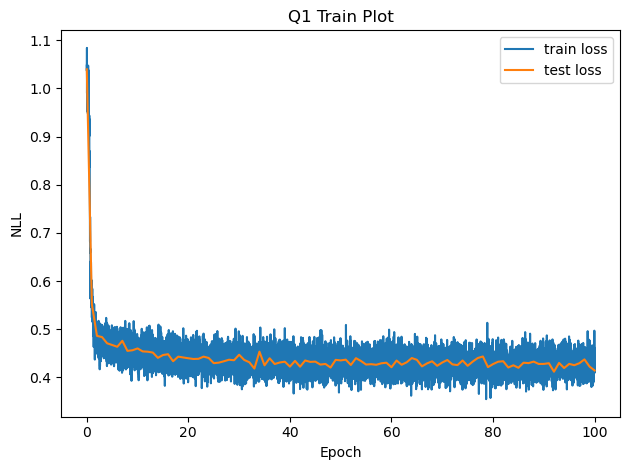

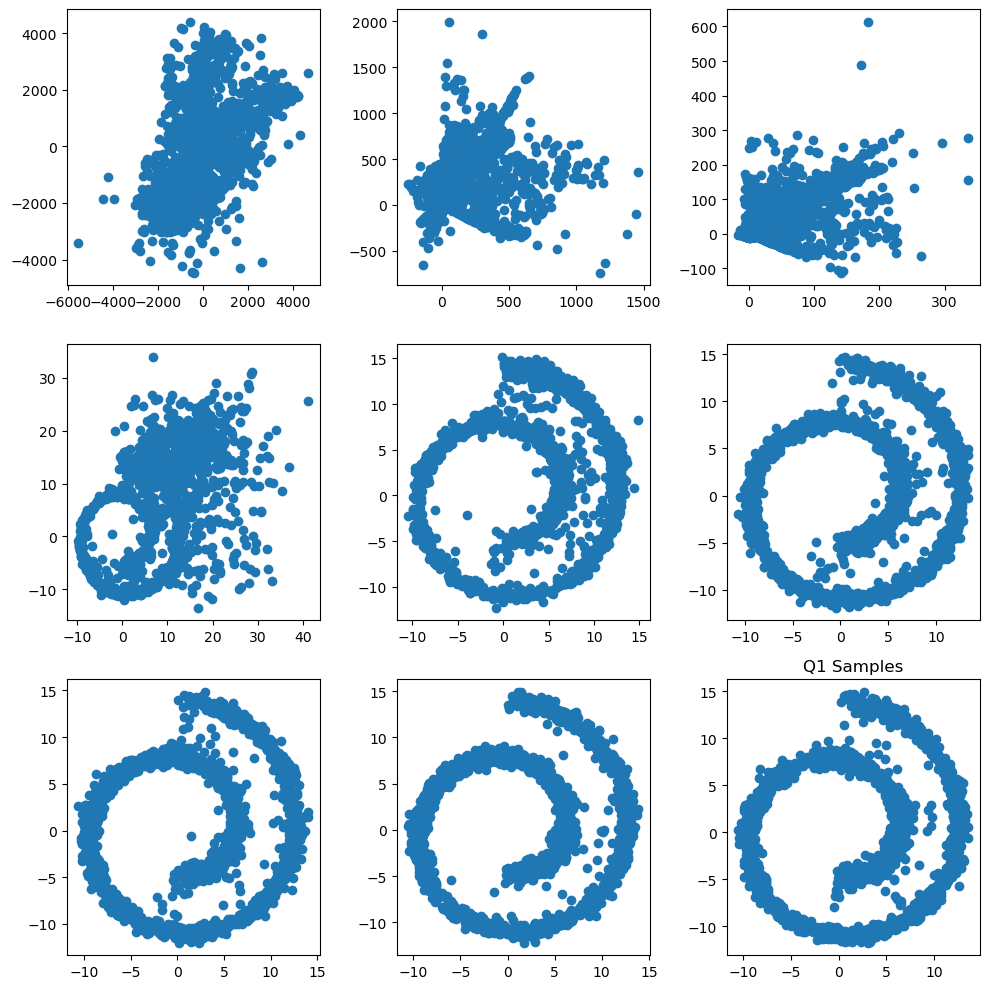

In [15]:
q1_save_results(q1)